<a href="https://colab.research.google.com/github/HarishTulsiyan/Image-Captioning-/blob/master/Image_Captioning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip
!unzip glove.6B.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430526230_234b3550f6.jpg  
  inflating: Flicker8k_Dataset/3430607596_7e4f74e3ff.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430607596_7e4f74e3ff.jpg  
  inflating: Flicker8k_Dataset/343073813_df822aceac.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._343073813_df822aceac.jpg  
  inflating: Flicker8k_Dataset/3430779304_43a2146f4b.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._343077

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
import string
import glob

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [0]:
root_captioning = '/content'

In [0]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]
  

In [6]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)


8092
8763
32


In [0]:
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [8]:
len(img)

8091

In [0]:
train_images_path = os.path.join(root_captioning,'Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

In [10]:
print(len(train_images))
print(len(test_images))

6000
1000


In [0]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [12]:
len(train_descriptions)

6000

In [13]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

96116736/96112376 [==============================] - 1s 0us/step


In [14]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [19]:
train_path = os.path.join('/content/gdrive/My Drive/Data Sets',"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

100%|██████████| 6000/6000 [04:17<00:00, 23.34it/s]



Generating training set took: 0:04:17.34


In [20]:
test_path = os.path.join('/content/gdrive/My Drive/Data Sets',"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 1000/1000 [00:43<00:00, 22.95it/s]



Generating testing set took: 0:00:43.61


In [21]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [22]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [23]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [24]:
max_length +=2
print(max_length)

34


In [0]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key + '.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [27]:

embeddings_index = {} 
f = open(os.path.join(root_captioning, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:19, 20108.04it/s]

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [29]:
embedding_matrix.shape

(1652, 200)

In [0]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [31]:
embedding_dim

200

In [32]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [35]:
model_path = os.path.join('/content/gdrive/My Drive/Data Sets',"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)
    

  0%|          | 0/20 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.fit, which supports generators.
2000/2000 [==============================] - 170s 85ms/step - loss: 4.1250


  5%|▌         | 1/20 [02:53<54:50, 173.17s/it]

2000/2000 [==============================] - 172s 86ms/step - loss: 3.4223


 10%|█         | 2/20 [05:45<51:49, 172.77s/it]

2000/2000 [==============================] - 169s 85ms/step - loss: 3.2047


 15%|█▌        | 3/20 [08:34<48:39, 171.73s/it]

2000/2000 [==============================] - 168s 84ms/step - loss: 3.0751


 20%|██        | 4/20 [11:22<45:31, 170.70s/it]

2000/2000 [==============================] - 168s 84ms/step - loss: 2.9813


 25%|██▌       | 5/20 [14:10<42:26, 169.79s/it]

2000/2000 [==============================] - 169s 84ms/step - loss: 2.9081


 30%|███       | 6/20 [16:58<39:32, 169.45s/it]

2000/2000 [==============================] - 168s 84ms/step - loss: 2.8501


 35%|███▌      | 7/20 [19:47<36:38, 169.08s/it]

2000/2000 [==============================] - 168s 84ms/step - loss: 2.8043


 40%|████      | 8/20 [22:34<33:43, 168.65s/it]

2000/2000 [==============================] - 167s 84ms/step - loss: 2.7614


 45%|████▌     | 9/20 [25:21<30:50, 168.20s/it]

2000/2000 [==============================] - 167s 83ms/step - loss: 2.7261


 50%|█████     | 10/20 [28:08<27:57, 167.76s/it]

2000/2000 [==============================] - 167s 83ms/step - loss: 2.6984


 55%|█████▌    | 11/20 [30:55<25:08, 167.56s/it]

2000/2000 [==============================] - 167s 84ms/step - loss: 2.6733


 60%|██████    | 12/20 [33:42<22:19, 167.44s/it]

2000/2000 [==============================] - 168s 84ms/step - loss: 2.6468


 65%|██████▌   | 13/20 [36:31<19:34, 167.73s/it]

2000/2000 [==============================] - 168s 84ms/step - loss: 2.6276


 70%|███████   | 14/20 [39:19<16:46, 167.80s/it]

2000/2000 [==============================] - 167s 83ms/step - loss: 2.6104


 75%|███████▌  | 15/20 [42:06<13:57, 167.50s/it]

2000/2000 [==============================] - 166s 83ms/step - loss: 2.5913


 80%|████████  | 16/20 [44:52<11:08, 167.07s/it]

2000/2000 [==============================] - 166s 83ms/step - loss: 2.5744


 85%|████████▌ | 17/20 [47:38<08:20, 166.82s/it]

2000/2000 [==============================] - 170s 85ms/step - loss: 2.5627


 90%|█████████ | 18/20 [50:28<05:35, 167.87s/it]

2000/2000 [==============================] - 172s 86ms/step - loss: 2.5483


 95%|█████████▌| 19/20 [53:20<02:49, 169.17s/it]

2000/2000 [==============================] - 173s 87ms/step - loss: 2.5355


100%|██████████| 20/20 [56:14<00:00, 168.71s/it]

   1/1000 [..............................] - ETA: 0s - loss: 2.6833

1000/1000 [==============================] - 88s 88ms/step - loss: 2.3804
\Training took: 1:13:10.76


In [0]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

/content/Flicker8k_Dataset/3498997518_c2b16f0a0e.jpg


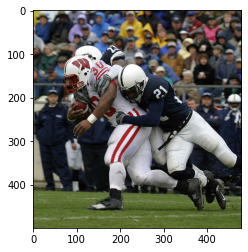

Caption: football player in red uniform is the player in white for the ball
_____________________________________
/content/Flicker8k_Dataset/2196846255_2c1635359a.jpg


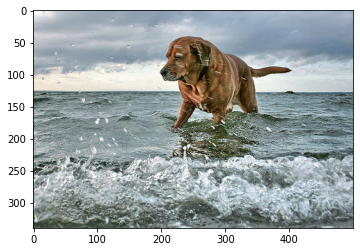

Caption: brown dog is running through the water
_____________________________________
/content/Flicker8k_Dataset/2295750198_6d152d7ceb.jpg


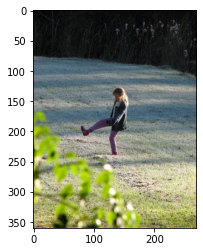

Caption: young girl in pink shirt and blue jeans is running through the grass
_____________________________________
/content/Flicker8k_Dataset/3745451546_fc8ec70cbd.jpg


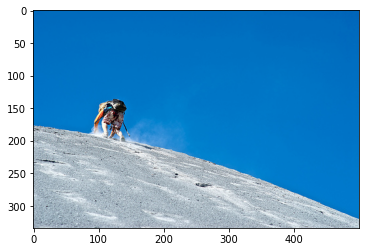

Caption: man is standing on top of mountain overlooking the ocean
_____________________________________
/content/Flicker8k_Dataset/180094434_b0f244832d.jpg


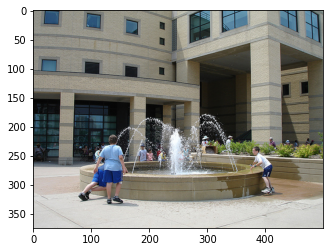

Caption: woman in red shirt and heels is walking down the street
_____________________________________
/content/Flicker8k_Dataset/2938120171_970564e3d8.jpg


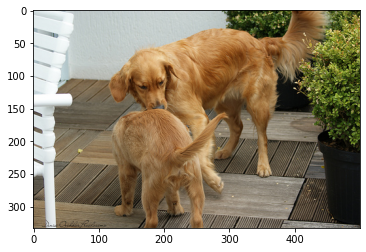

Caption: dog is running through the grass
_____________________________________
/content/Flicker8k_Dataset/1554713437_61b64527dd.jpg


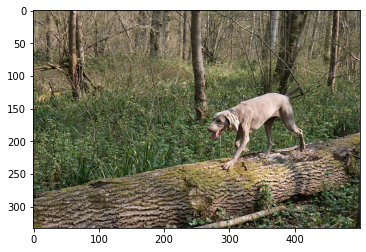

Caption: dog runs through the woods
_____________________________________
/content/Flicker8k_Dataset/2075321027_c8fcbaf581.jpg


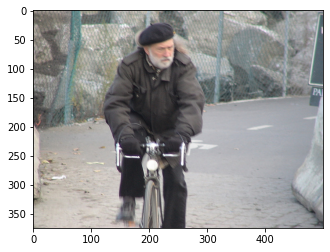

Caption: man and woman are walking past brick building
_____________________________________
/content/Flicker8k_Dataset/3220161734_77f42734b9.jpg


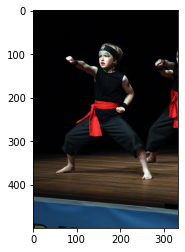

Caption: boy in red shirt and blue jeans is running on track
_____________________________________
/content/Flicker8k_Dataset/2541104331_a2d65cfa54.jpg


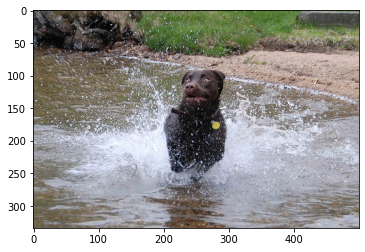

Caption: dog is swimming in the water
_____________________________________


In [37]:
for z in range(10):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")